In [1]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev==2.3.29
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path

def plot_label_counts(dls):
    # Inicializar listas para etiquetas de training (originales y destiladas)
    train_original_labels = []
    train_distilled_labels = []

    # Recorrer cada ejemplo en el dataset de training
    for i in range(len(dls.train_ds)):
        label = int(dls.train_ds[i][1])
        # Obtener la ruta del archivo y extraer el nombre
        path = Path(dls.train_ds.items[i])
        filename = path.name.lower()  # convertir a minúsculas para evitar problemas con mayúsculas

        # Clasificar: si el nombre comienza con 'distilled', es destilado; de lo contrario, es original.
        if filename.startswith("distilled"):
            train_distilled_labels.append(label)
        else:
            train_original_labels.append(label)

    # Para validación, todas las imágenes se consideran originales
    valid_labels = [int(dls.valid_ds[i][1]) for i in range(len(dls.valid_ds))]

    # Contar el número de ejemplos por etiqueta en cada grupo
    train_orig_counts = Counter(train_original_labels)
    train_dist_counts = Counter(train_distilled_labels)
    valid_counts = Counter(valid_labels)

    # Obtenemos el vocabulario (lista de nombres de clases) y el número de clases:
    vocab = dls.vocab
    n_classes = len(vocab)

    # Crear listas de conteos para cada clase (asumiendo índices de 0 a n_classes-1)
    orig_data = [train_orig_counts[i] for i in range(n_classes)]
    dist_data = [train_dist_counts[i] for i in range(n_classes)]
    valid_data = [valid_counts[i] for i in range(n_classes)]

    # Configurar el gráfico de barras agrupadas:
    x = np.arange(n_classes)
    width = 0.25  # ancho de cada barra, para acomodar tres barras por etiqueta

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width, orig_data, width, label='Train Original', color='blue')
    ax.bar(x, dist_data, width, label='Train Distilled', color='red')
    ax.bar(x + width, valid_data, width, label='Valid', color='yellow')

    ax.set_ylabel('Número de elementos')
    ax.set_xticks(x)
    ax.set_xticklabels(vocab)
    ax.legend()

    plt.show()


# Apartado 1

In [4]:
os.environ["FASTAI_HOME"] = str(Path('/content/dataset'))

try:
  path = untar_data(URLs.CIFAR)
except Exception as e:
  print(f"Error al descargar el dataset: {e}")


In [5]:
# Definir rutas para la organización
base_path = Path('/content/dataset')
original_path = base_path / "original"

original_path.mkdir(parents=True, exist_ok=True)

dest_original = original_path / path.name
if not dest_original.exists():
    shutil.move(str(path), str(dest_original))
    print(f"Dataset movido a: {dest_original}")
else:
    print("El dataset ya se encuentra en la carpeta original.")

Dataset movido a: /content/dataset/original/cifar10


In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Lenet

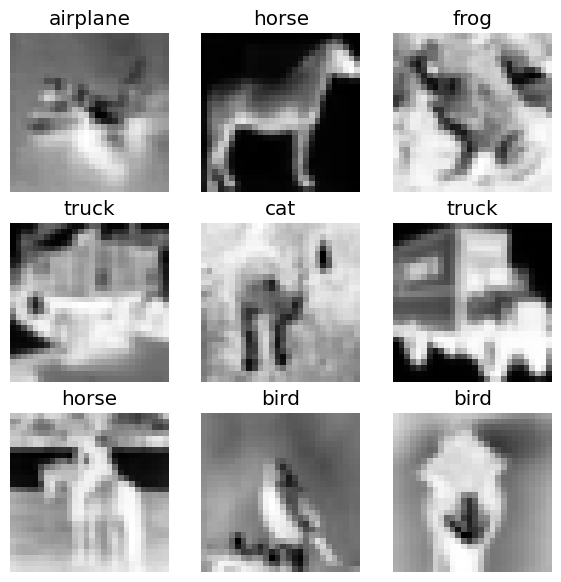

In [ ]:
# Crear los DataLoaders
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(28)
)

# Crear los DataLoaders
dls = blocks.dataloaders(original_path/'cifar10'/'train', bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 40000
Número total de imágenes en validación: 10000

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


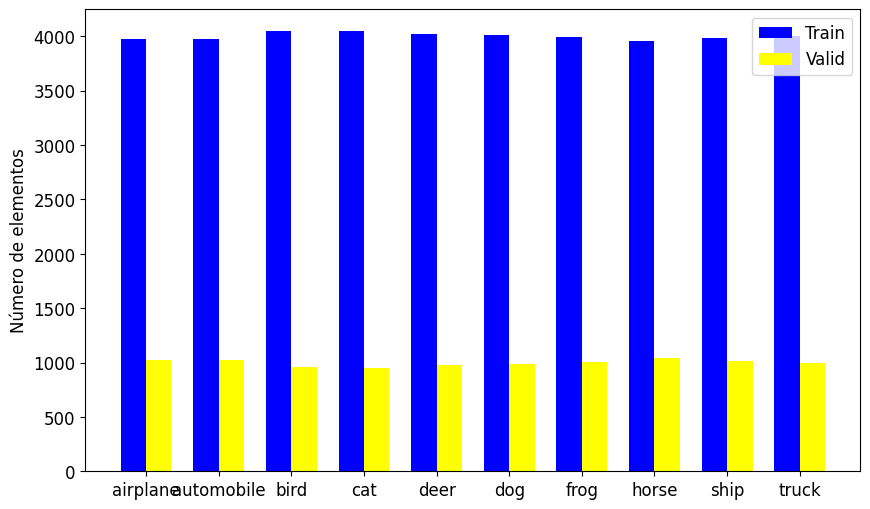

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class LeNet(nn.Module):
  def __init__(self, num_classes=10):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)  # Aplanar la salida
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

learn.summary()

LeNet (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 24 x 24    
Conv2d                                    156        True      
____________________________________________________________________________
                     64 x 16 x 8 x 8     
Conv2d                                    2416       True      
____________________________________________________________________________
                     64 x 16 x 4 x 4     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 120            
Linear                                    30840      True      
____________________________________________________________________________
                     64 x 84             
Linear                                    10164      True      
____________________________________________________________

In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.228228,2.205205,0.181800,0.184543,0.138305,01:03
1,2.041262,2.005547,0.282500,0.283940,0.275873,01:18
2,1.826973,1.807369,0.342700,0.343849,0.328343,01:15
3,1.722906,1.703664,0.379100,0.381274,0.370269,01:19
4,1.645619,1.687688,0.385700,0.387500,0.375721,01:00
5,1.558953,1.591059,0.430900,0.433137,0.423742,01:00
6,1.484773,1.539041,0.446800,0.447416,0.436892,01:01
7,1.451758,1.525388,0.464400,0.465662,0.457085,00:59
8,1.406875,1.451187,0.476300,0.478823,0.471705,00:59
9,1.385579,1.426195,0.488000,0.489789,0.483902,01:00



Tiempo de entrenamiento: 1261.63 segundos


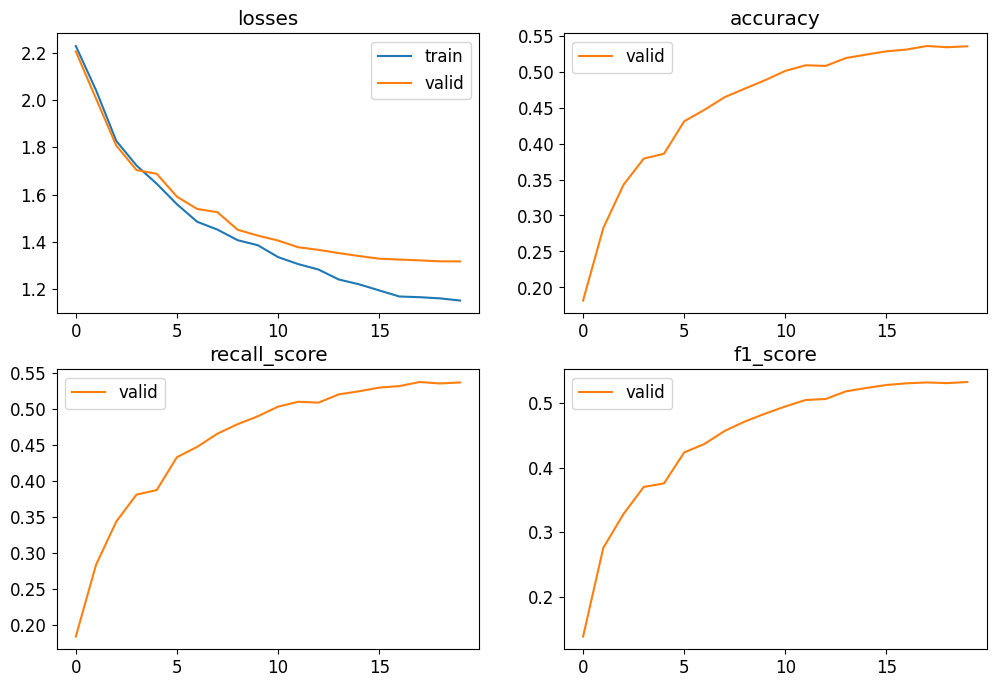

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.3172
Accuracy: 0.5351
Recall: 0.5367
F1-Score: 0.5330


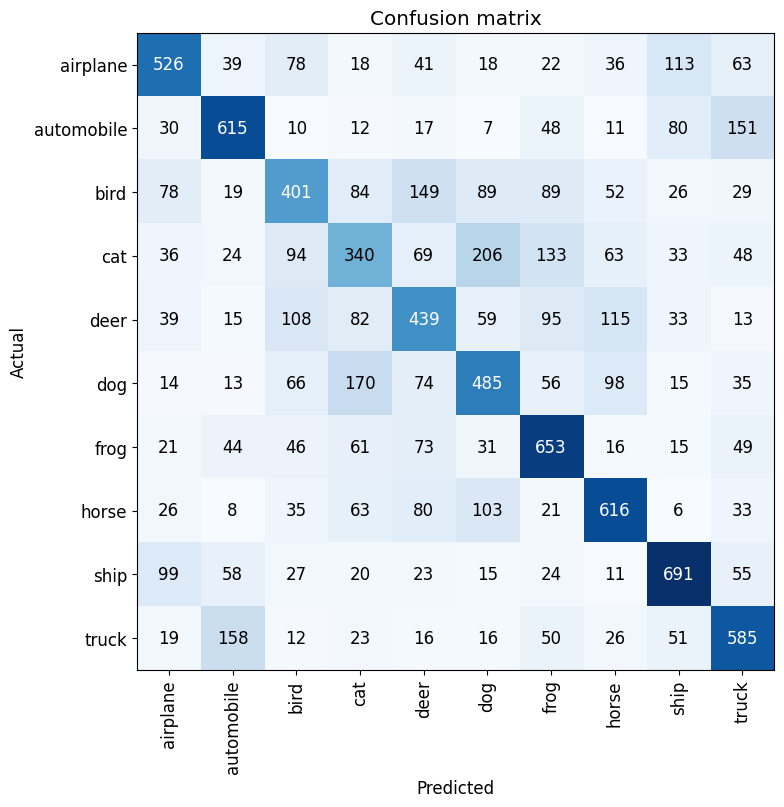

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_original_v2.pkl')

## Resnet18

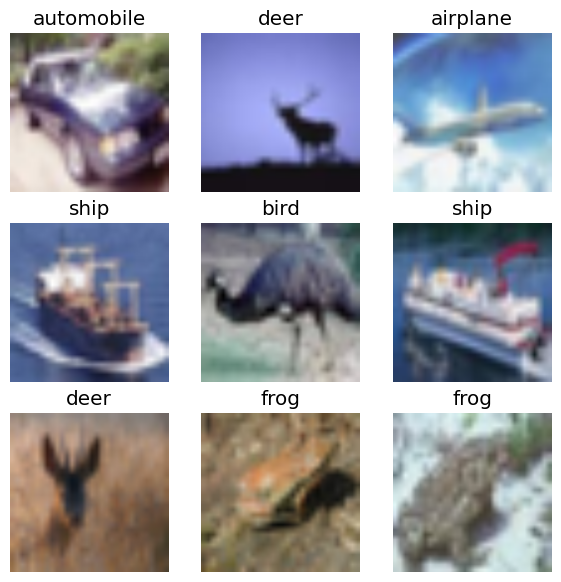

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

dls = dblock.dataloaders(original_path/'cifar10'/'train', bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Crear el learner con resnet18
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Entrenar el modelo
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.090381,2.122317,0.323900,0.325420,0.284721,03:01
1,1.613373,2.803111,0.315700,0.317923,0.287236,02:47
2,1.167108,1.218266,0.582400,0.583148,0.589631,02:47
3,0.847544,0.877221,0.694600,0.696690,0.689745,02:46
4,0.708340,0.735071,0.752300,0.751598,0.753957,02:46
5,0.566715,0.571304,0.805200,0.805323,0.805512,02:45
6,0.471611,0.535082,0.818600,0.819446,0.818475,02:46
7,0.394259,0.596442,0.807900,0.808854,0.808261,02:47
8,0.294328,0.515420,0.836700,0.836666,0.837540,02:46
9,0.215291,0.533767,0.842500,0.843161,0.842854,02:46


No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 2015.55 segundos


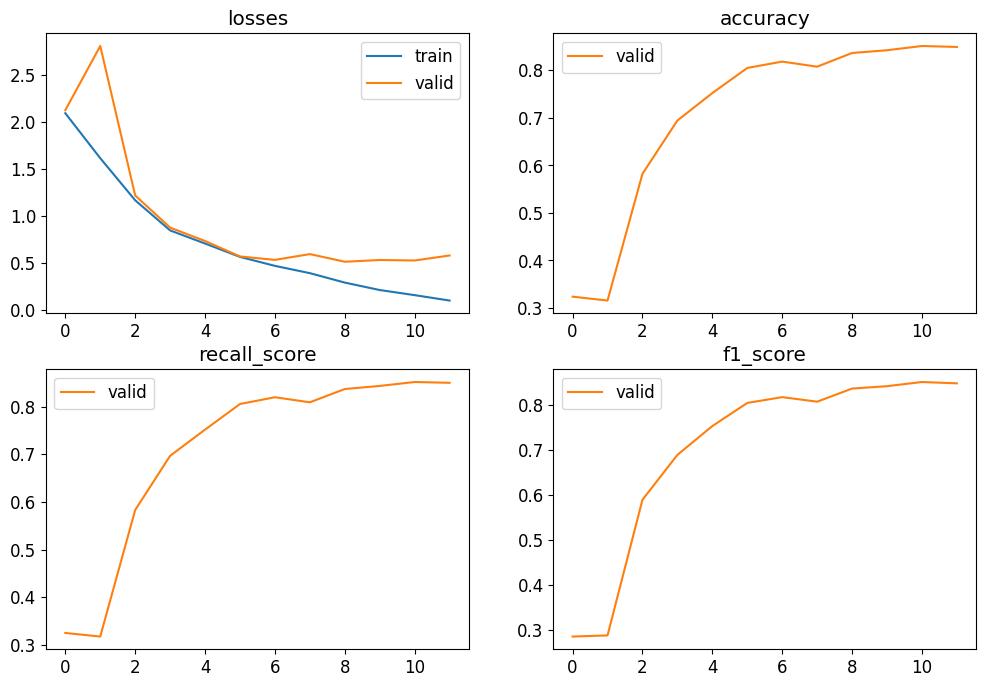

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.5817
Accuracy: 0.8494
Recall: 0.8497
F1-Score: 0.8492


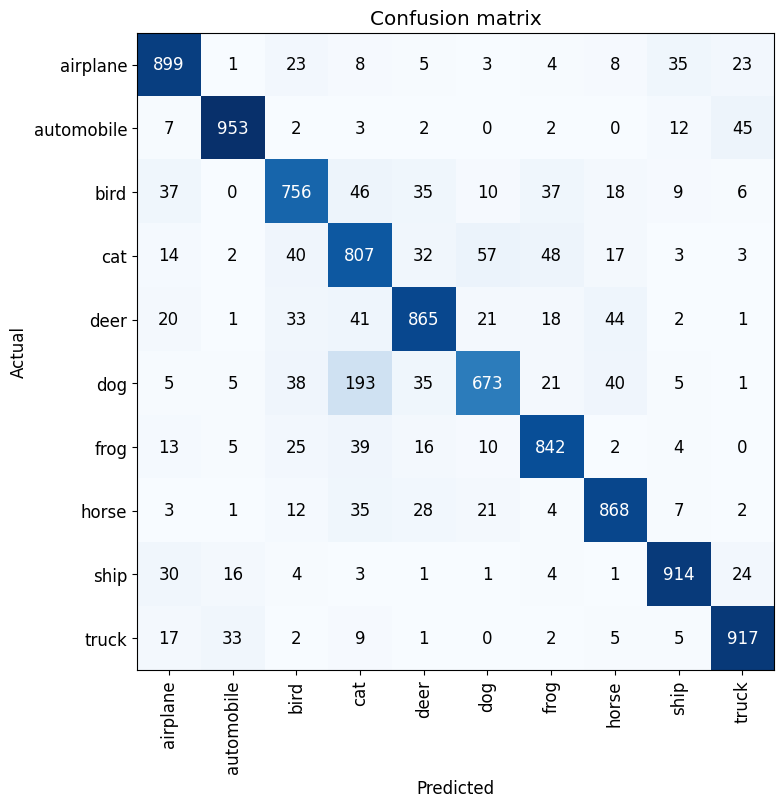

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_original_v2.pkl')

# Apartado 2

## Data destilacion

In [7]:
import random
import shutil
from pathlib import Path
import numpy as np
from PIL import Image

def media_arit(image_paths):
    avg_image = None
    count = 0
    for img_path in image_paths:
        with Image.open(img_path) as img:
            np_img = np.array(img, dtype=np.float32)
            if avg_image is None:
                avg_image = np_img
            else:
                avg_image += np_img
            count += 1
    avg_image /= count
    avg_image = np.clip(avg_image, 0, 255).astype(np.uint8)
    return Image.fromarray(avg_image)  # PIL infiere el modo según la forma

In [8]:
def create_partial_distilled(src_path, dst_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=1, mix_function=media_arit):
    """
    Crea un nuevo dataset a partir de src_path con la siguiente estrategia:

      - Se divide en 80% training y 20% validación (valid_ratio).
      - En el conjunto de training:
          * El 80% de las imágenes se procesan mediante destilación usando mix_function.
          * El 20% restante se copia sin modificar.
      - En el conjunto de validación se copian las imágenes sin modificaciones.

    Parámetros:
      src_path: Ruta a la carpeta original, que debe tener subcarpetas para cada clase.
      dst_path: Ruta destino para el nuevo dataset.
      valid_ratio: Proporción de imágenes para validación (ej. 0.2 para 20%).
      distilled_portion: Proporción de imágenes dentro del training que serán destiladas (ej. 0.8 para 80%).
      group_fraction:
          * Si es 1, se mezclan todas las imágenes del subconjunto de destilación en una sola imagen.
          * Si es un valor entre 0 y 1, se agrupan en bloques cuyo tamaño es group_size = int(len(distilled_images) * group_fraction).
          * Si es 0, se procesa cada imagen individualmente (aunque normalmente querrás usar 1 o un valor intermedio).
      mix_function: Función que recibe una lista de rutas de imágenes y devuelve una imagen destilada.
    """
    src_path = Path(src_path)
    dst_path = Path(dst_path)

    # Eliminar dst_path si ya existe
    if dst_path.exists():
        shutil.rmtree(dst_path)
    dst_path.mkdir(parents=True, exist_ok=True)

    # Crear directorios para training y validación
    train_dst = dst_path / "training"
    valid_dst = dst_path / "valid"
    train_dst.mkdir(parents=True, exist_ok=True)
    valid_dst.mkdir(parents=True, exist_ok=True)

    # Procesar cada subcarpeta (clase) en src_path
    for class_dir in src_path.iterdir():
        if not class_dir.is_dir():
            continue

        images = list(class_dir.glob('*.*'))
        if not images:
            continue

        # Barajar y separar en training y validación
        random.shuffle(images)
        total = len(images)
        n_valid = int(total * valid_ratio)
        n_train = total - n_valid

        train_images = images[:n_train]
        valid_images = images[n_train:]

        # Dentro de training, separar el 80% para destilación y el 20% para copiar sin modificar
        n_train_distilled = int(n_train * distilled_portion)
        n_train_original = n_train - n_train_distilled

        distilled_images = train_images[:n_train_distilled]
        original_train_images = train_images[n_train_distilled:]

        # Crear subdirectorios para la clase en training y validación
        new_train_class_dir = train_dst / class_dir.name
        new_train_class_dir.mkdir(parents=True, exist_ok=True)
        new_valid_class_dir = valid_dst / class_dir.name
        new_valid_class_dir.mkdir(parents=True, exist_ok=True)

        # Procesar las imágenes para destilación (80% del conjunto de training)
        if group_fraction == 0:
            # Procesar cada imagen individualmente (aunque esto normalmente no es lo esperado)
            for img_path in distilled_images:
                distilled_img = mix_function([img_path])
                # Se guarda con el mismo nombre original
                new_file = new_train_class_dir / img_path.name
                distilled_img.save(new_file)
        elif group_fraction == 1:
            # Mezclar todas las imágenes del subconjunto en una sola imagen destilada
            distilled_img = mix_function(distilled_images)
            distilled_filename = new_train_class_dir / "distilled.jpg"
            distilled_img.save(distilled_filename)
        else:
            # Agrupar las imágenes en bloques
            group_size = max(1, int(len(distilled_images) * group_fraction))
            group_count = 0
            for i in range(0, len(distilled_images), group_size):
                group = distilled_images[i:i + group_size]
                distilled_img = mix_function(group)
                distilled_filename = new_train_class_dir / f"distilled_{group_count}.jpg"
                distilled_img.save(distilled_filename)
                group_count += 1

        # Copiar las imágenes originales (20% de training) sin modificar
        for img_path in original_train_images:
            shutil.copy(img_path, new_train_class_dir)

        # En validación se copian todas las imágenes sin procesar
        for img_path in valid_images:
            shutil.copy(img_path, new_valid_class_dir)


In [9]:
cifar_001_path = base_path / "distilled_001"
cifar_001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'cifar10'/'train', cifar_001_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.01, mix_function=media_arit)


In [10]:
cifar_005_path = base_path / "distilled_005"
cifar_005_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'cifar10'/'train', cifar_005_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.05, mix_function=media_arit)


In [11]:
cifar_0001_path = base_path / "distilled_0001"
cifar_0001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'cifar10'/'train', cifar_0001_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.001, mix_function=media_arit)


In [17]:
def umbralizacion_tri(img: PILImage):
    return img.quantize(colors=3)

In [ ]:
def umbralizacion_bi(img: PILImage):
    return img.quantize(colors=2)

In [ ]:
import cv2

def otsu_threshold_transform(img: PILImage):
    #img_gray = img.convert("L")
    img_array = np.array(img)
    _, thresholded = cv2.threshold(img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return PILImage.create(thresholded)

In [34]:
test_path = Path('/content/dataset/original/cifar10/test')

## Lenet 001 - v1

In [ ]:
dst = base_path / "distilled_001"

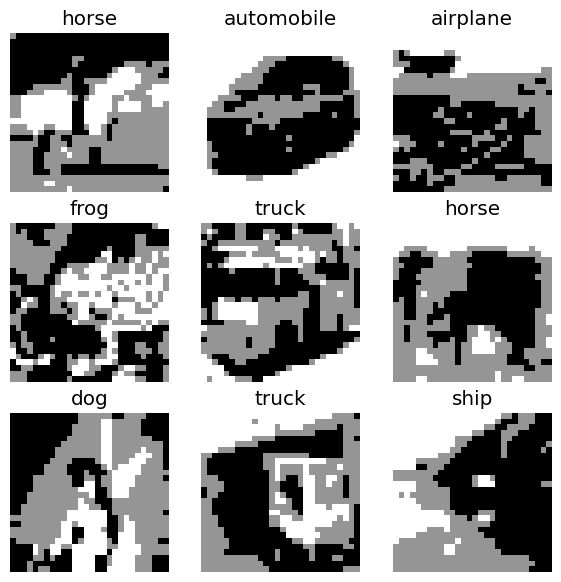

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(28), umbralizacion_tri]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 9000
Número total de imágenes en validación: 10000

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


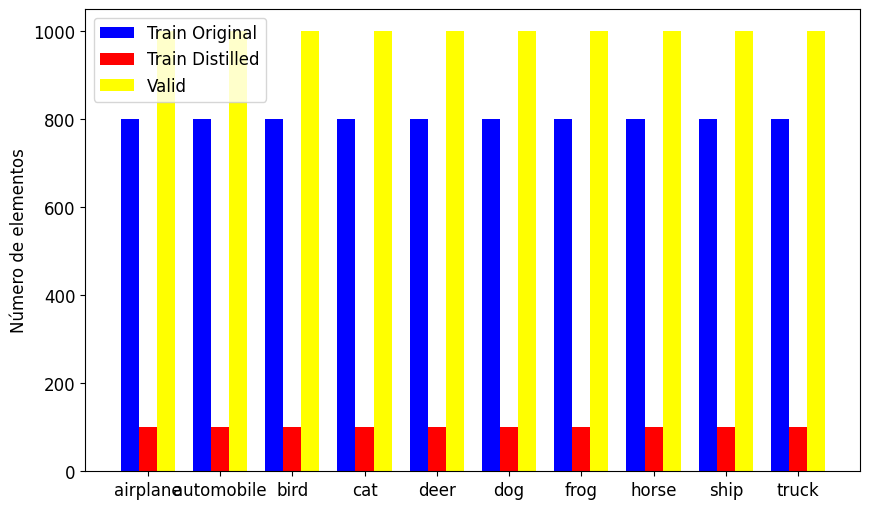

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[Resize(28), umbralizacion_tri]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

### Lenet 001 - Example 2

In [ ]:
dst = base_path / "distilled_001"

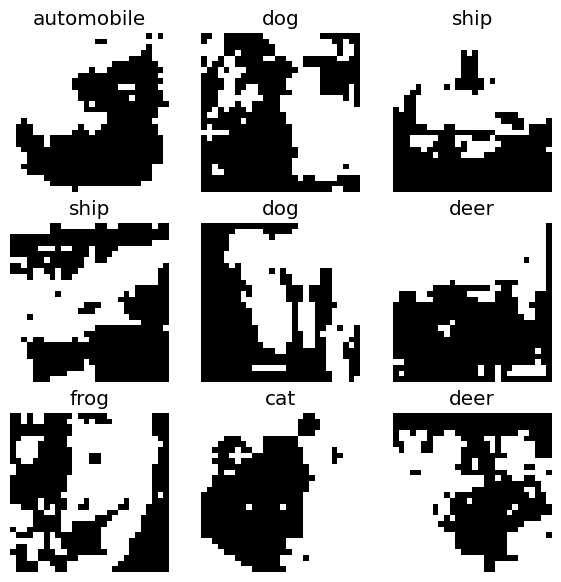

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(28), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.305148,2.303619,0.100000,0.100000,0.018182,00:38
1,2.303849,2.302692,0.100000,0.100000,0.018182,00:40
2,2.303286,2.302741,0.100000,0.100000,0.018182,00:39
3,2.303384,2.302647,0.100000,0.100000,0.018182,00:38
4,2.303269,2.302634,0.100000,0.100000,0.018182,00:39
5,2.171522,2.257592,0.174700,0.174700,0.122533,00:38
6,1.995804,2.281681,0.187300,0.187300,0.154026,00:39
7,1.942223,2.275396,0.192900,0.192900,0.169867,00:39
8,1.893827,2.228633,0.210900,0.210900,0.193387,00:37
9,1.834648,2.266080,0.207900,0.207900,0.194765,00:39


No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 547.31 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.2802
Accuracy: 0.2150
Recall: 0.2150
F1-Score: 0.2043


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[Resize(28), umbralizacion_bi]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.2772586345672607
Accuracy: 0.2215544879436493
Recall (macro): 0.22157428677728497
F1 Score (macro): 0.2101820838837986


### Lenet 001 - Example 3

In [ ]:
dst = base_path / "distilled_001"

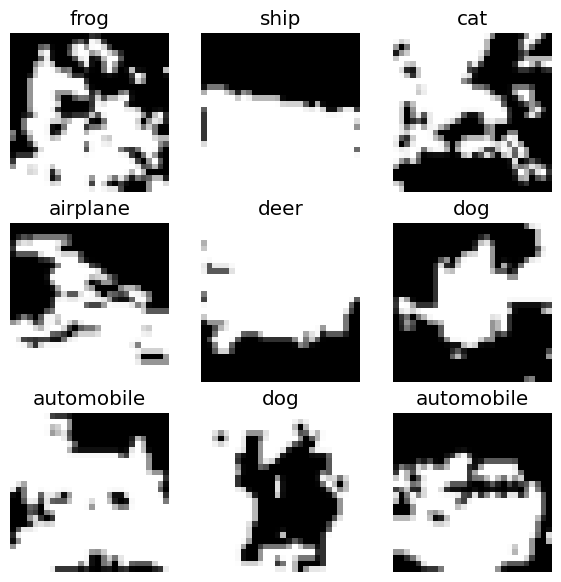

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(28), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.295465,2.293003,0.146800,0.146800,0.067932,00:47
1,2.009308,2.269544,0.183300,0.183300,0.157871,00:45
2,1.843314,2.205494,0.236800,0.236800,0.233184,00:37
3,1.688380,2.066377,0.275000,0.275000,0.266886,00:35
4,1.589773,2.193679,0.260900,0.260900,0.252369,00:37
5,1.532166,2.046230,0.301700,0.301700,0.297552,00:36
6,1.480734,2.037508,0.307700,0.307700,0.304816,00:35
7,1.453534,1.990651,0.319400,0.319400,0.310342,00:38
8,1.407962,2.017159,0.317200,0.317200,0.311388,00:36
9,1.377654,2.048152,0.318800,0.318800,0.317920,00:37


No improvement since epoch 11: early stopping

Tiempo de entrenamiento: 646.55 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.0226
Accuracy: 0.3480
Recall: 0.3480
F1-Score: 0.3467


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[Resize(28), otsu_threshold_transform]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.0280089378356934
Accuracy: 0.3509615361690521
Recall (macro): 0.35091682093527277
F1 Score (macro): 0.3488262885187393


## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

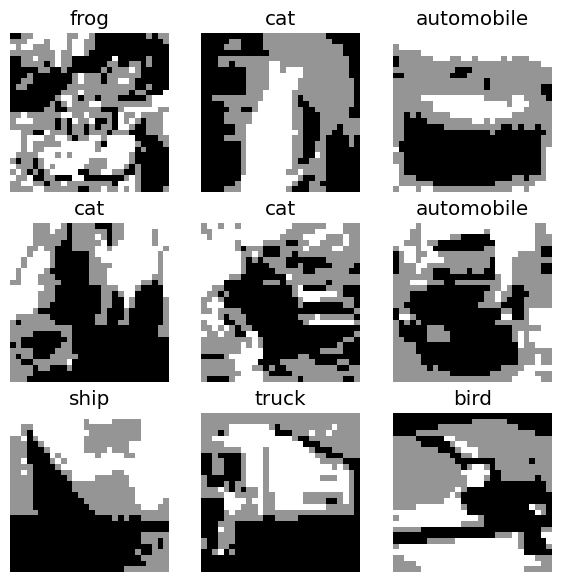

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(28), umbralizacion_tri]

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 8200
Número total de imágenes en validación: 10000

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


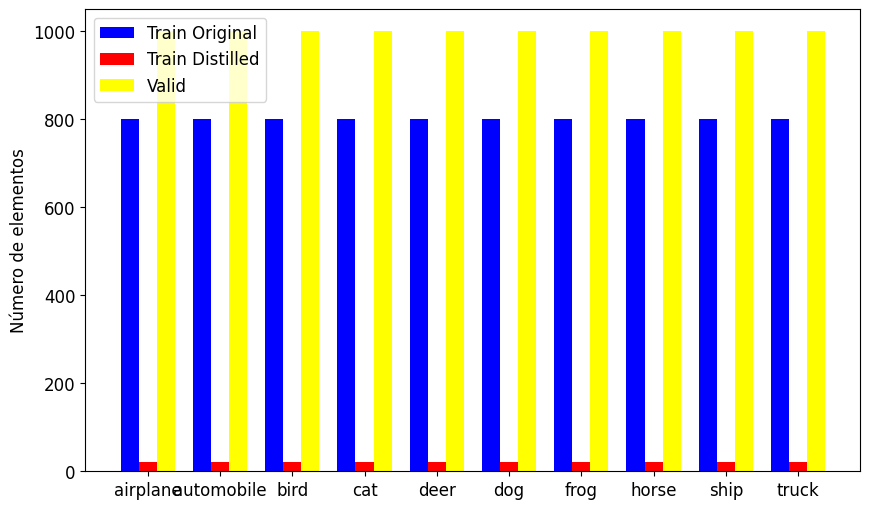

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.304875,2.304604,0.100000,0.100000,0.018182,00:35
1,2.303877,2.303114,0.100000,0.100000,0.018182,00:36
2,2.303540,2.302759,0.100000,0.100000,0.018182,00:37
3,2.303598,2.302633,0.100000,0.100000,0.018182,00:35
4,2.303417,2.302734,0.100000,0.100000,0.018182,00:36
5,2.303275,2.302595,0.100000,0.100000,0.018182,00:35
6,2.303085,2.302247,0.100000,0.100000,0.018182,00:37
7,2.290115,2.265494,0.153800,0.153800,0.097188,00:35
8,2.210653,2.214921,0.169800,0.169800,0.126413,00:37
9,2.172405,2.178223,0.196200,0.196200,0.135594,00:36



Tiempo de entrenamiento: 724.73 segundos


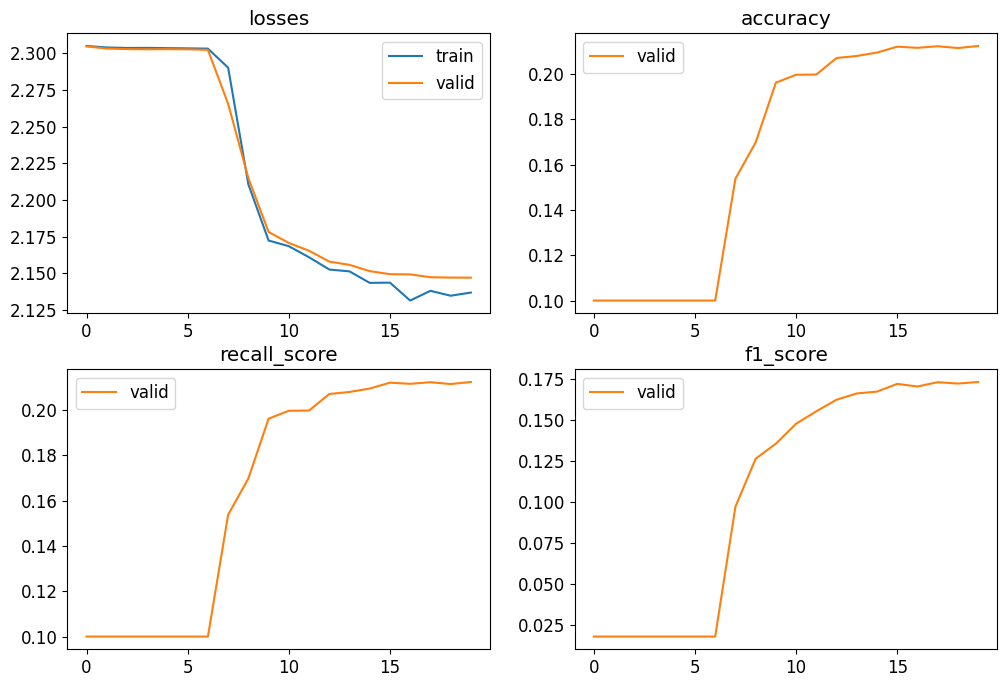

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.1471
Accuracy: 0.2124
Recall: 0.2124
F1-Score: 0.1731


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[Resize(28), umbralizacion_tri]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.1606626510620117
Accuracy: 0.20913460850715637
Recall (macro): 0.20918548400602494
F1 Score (macro): 0.17174089951386778


### Lenet 005 - Example 2

In [ ]:
create_distilled(original_path/'mnist_png'/'training', mnist_005_path, valid_ratio=0.2, fraction=0.05, mix_function=media_arit)

In [ ]:
dst = base_path / "distilled_005"

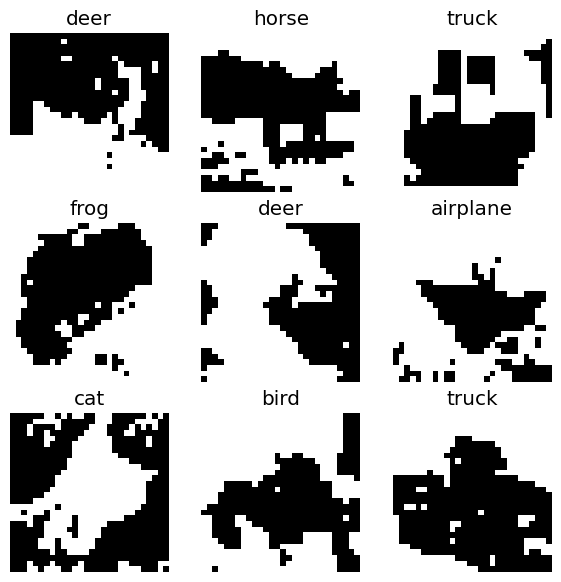

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(28), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.304230,2.303909,0.100000,0.100000,0.018182,00:36
1,2.303535,2.302900,0.100000,0.100000,0.018182,00:53
2,2.303455,2.302939,0.100000,0.100000,0.018182,00:43
3,2.303359,2.302816,0.100000,0.100000,0.018182,00:35
4,2.303432,2.302685,0.100000,0.100000,0.018182,00:37
5,2.303292,2.302627,0.100000,0.100000,0.018182,00:35
6,2.303210,2.302601,0.100000,0.100000,0.018182,00:37
7,2.303260,2.302649,0.100000,0.100000,0.018182,00:35
8,2.303228,2.302603,0.100000,0.100000,0.018182,00:36
9,2.303066,2.302601,0.100000,0.100000,0.018182,00:36



Tiempo de entrenamiento: 752.81 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.3026
Accuracy: 0.1000
Recall: 0.1000
F1-Score: 0.0182


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[Resize(28), umbralizacion_bi]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.3025872707366943
Accuracy: 0.09975961595773697
Recall (macro): 0.1
F1 Score (macro): 0.01814207650273224


### Lenet 005 - Example 3

In [ ]:
dst = base_path / "distilled_005"

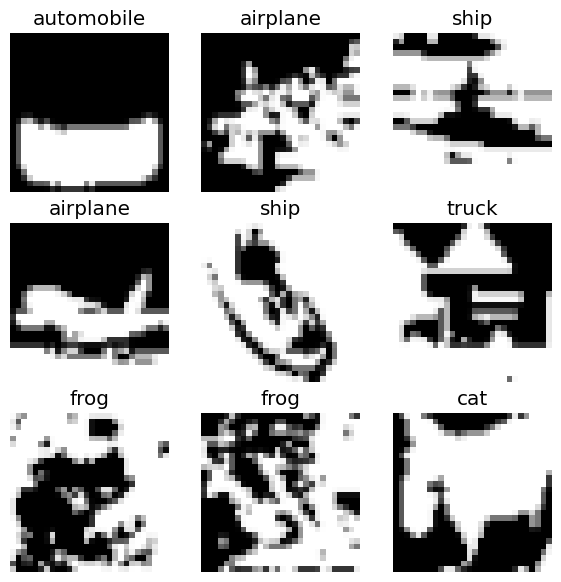

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(28), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.301178,2.297747,0.143000,0.143000,0.046952,00:33
1,2.222432,2.171917,0.204500,0.204500,0.169848,00:33
2,2.064722,2.018806,0.264000,0.264000,0.234334,00:36
3,1.954429,1.931530,0.298800,0.298800,0.273821,00:32
4,1.880099,1.875893,0.325300,0.325300,0.314395,00:32
5,1.833497,1.861198,0.327500,0.327500,0.312715,00:32
6,1.798419,1.836857,0.346600,0.346600,0.337883,00:33
7,1.754659,1.813682,0.356100,0.356100,0.346593,00:33
8,1.708193,1.787558,0.368900,0.368900,0.363120,00:32
9,1.676481,1.865867,0.347100,0.347100,0.337468,00:32



Tiempo de entrenamiento: 664.19 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.7333
Accuracy: 0.3949
Recall: 0.3949
F1-Score: 0.3899


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[Resize(28), otsu_threshold_transform]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.7487670183181763
Accuracy: 0.38461539149284363
Recall (macro): 0.38460483190774614
F1 Score (macro): 0.38043069646314087


## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

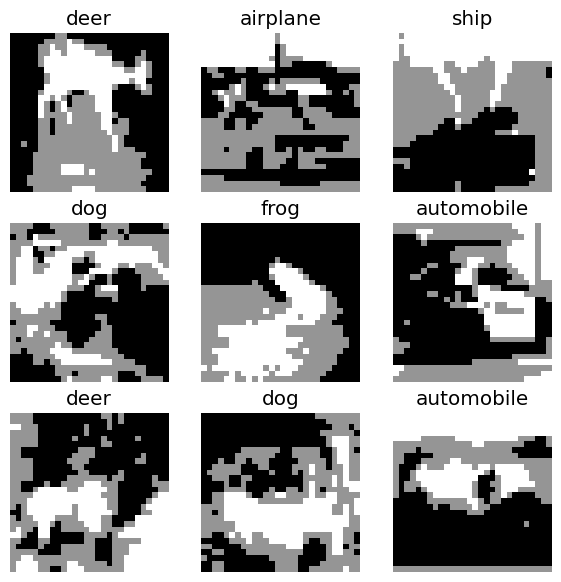

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(28), umbralizacion_tri]

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 18670
Número total de imágenes en validación: 10000

Clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


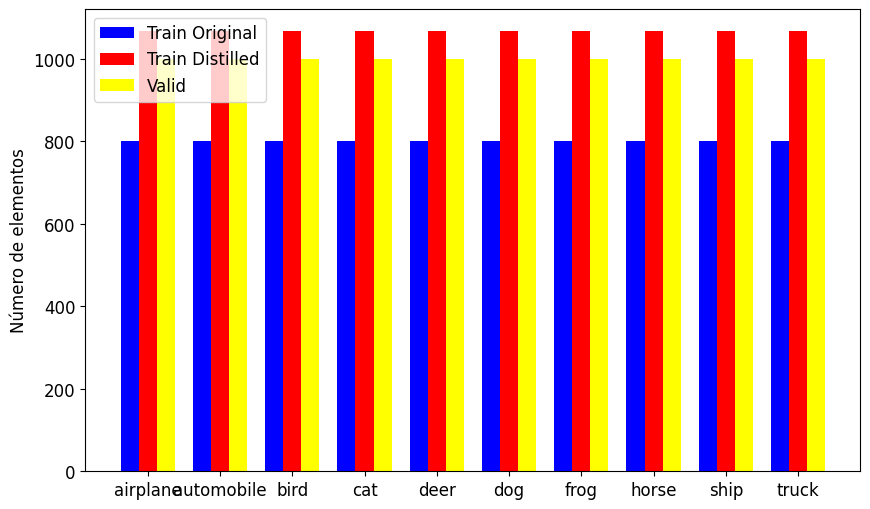

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303850,2.302994,0.100000,0.100000,0.018182,00:56
1,2.303212,2.302669,0.080200,0.080200,0.025293,00:57
2,2.303148,2.302695,0.100000,0.100000,0.018182,00:57
3,2.188838,2.206909,0.165100,0.165100,0.114463,00:56
4,2.079866,2.150928,0.204000,0.204000,0.179964,00:56
5,2.038042,2.108802,0.222300,0.222300,0.209652,00:57
6,1.993325,2.086326,0.233900,0.233900,0.223659,00:57
7,1.955794,2.063606,0.257700,0.257700,0.249222,00:56
8,1.935648,2.062713,0.260500,0.260500,0.246538,00:55
9,1.913922,2.038995,0.267600,0.267600,0.255444,00:56



Tiempo de entrenamiento: 1140.21 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.9890
Accuracy: 0.2892
Recall: 0.2892
F1-Score: 0.2855


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[Resize(28), umbralizacion_tri]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.011871814727783
Accuracy: 0.28545671701431274
Recall (macro): 0.2854273004439952
F1 Score (macro): 0.28185378447941734


### Lenet 0001 - Example 2

In [ ]:
create_distilled(original_path/'mnist_png'/'training', mnist_0001_path, valid_ratio=0.2, fraction=0.001, mix_function=media_arit)

In [ ]:
dst = base_path / "distilled_0001"

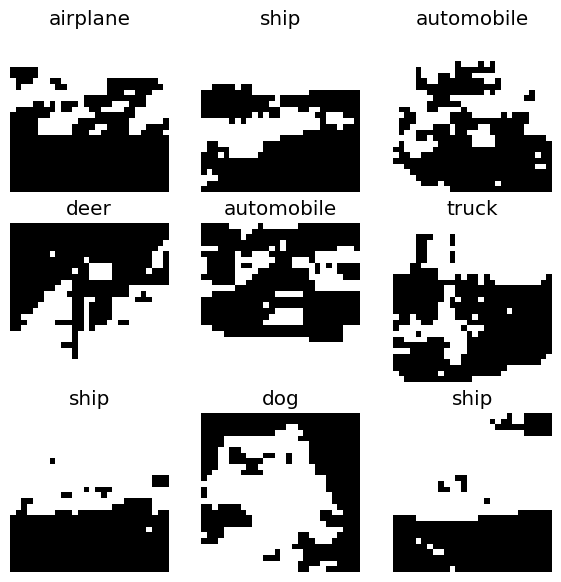

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(28), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303826,2.303000,0.100000,0.100000,0.018182,00:58
1,2.303069,2.302679,0.100000,0.100000,0.018182,00:57
2,2.302940,2.302671,0.100000,0.100000,0.018182,00:57
3,2.164431,2.195395,0.186800,0.186800,0.154785,00:57
4,2.025954,2.116624,0.224600,0.224600,0.210317,00:56
5,1.971826,2.084891,0.242700,0.242700,0.230656,00:57
6,1.941931,2.054909,0.251900,0.251900,0.239419,00:57
7,1.896595,2.010959,0.272300,0.272300,0.262464,00:57
8,1.861289,1.994446,0.280300,0.280300,0.266660,00:58
9,1.840994,1.964716,0.291600,0.291600,0.282440,00:56



Tiempo de entrenamiento: 1151.73 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.9273
Accuracy: 0.3107
Recall: 0.3107
F1-Score: 0.3071


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[Resize(28), umbralizacion_bi]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.944941759109497
Accuracy: 0.3035857379436493
Recall (macro): 0.30356570350428136
F1 Score (macro): 0.29985389447843475


### Lenet 0001 - Example 3

In [ ]:
create_distilled(original_path/'mnist_png'/'training', mnist_0001_path, valid_ratio=0.2, fraction=0.001, mix_function=media_arit)

In [ ]:
dst = base_path / "distilled_0001"

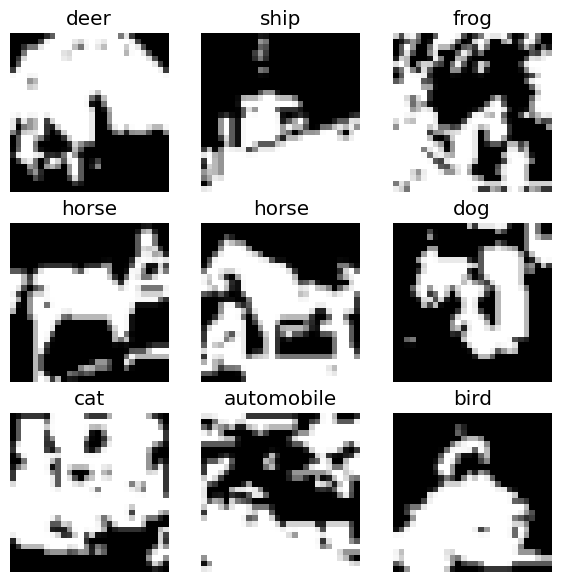

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(28), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.295892,2.291469,0.174600,0.174600,0.117006,00:51
1,1.973594,2.023150,0.260200,0.260200,0.251610,00:53
2,1.854255,1.955453,0.278600,0.278600,0.257559,00:51
3,1.767265,1.875196,0.330000,0.330000,0.309920,00:53
4,1.719375,1.890988,0.319600,0.319600,0.305094,00:51
5,1.665986,1.812396,0.346100,0.346100,0.333639,00:52
6,1.615042,1.759199,0.361500,0.361500,0.355868,00:53
7,1.569326,1.764900,0.370100,0.370100,0.361116,00:51
8,1.533229,1.724132,0.384900,0.384900,0.384796,00:53
9,1.505036,1.734673,0.385100,0.385100,0.378095,00:51



Tiempo de entrenamiento: 1049.98 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 1.6583
Accuracy: 0.4196
Recall: 0.4196
F1-Score: 0.4177


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[Resize(28), otsu_threshold_transform]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.6555566787719727
Accuracy: 0.42347756028175354
Recall (macro): 0.4234759715488619
F1 Score (macro): 0.42079768531477046


## Resnet 001

In [25]:
def umbralizacion_tri(img: PILImage):
    img_quant = img.quantize(colors=3).convert("L")
    arr = np.array(img_quant)
    arr_rgb = np.stack([arr]*3, axis=-1)            # Triplicamos el canal (H, W) -> (H, W, 3)
    return Image.fromarray(arr_rgb.astype('uint8'))


In [40]:
def umbralizacion_bi(img: PILImage):
    img_quant = img.quantize(colors=2).convert("L")
    arr = np.array(img_quant)
    arr_rgb = np.stack([arr]*3, axis=-1)            # Triplicamos el canal (H, W) -> (H, W, 3)
    return Image.fromarray(arr_rgb.astype('uint8'))


In [39]:
import cv2

def otsu_threshold_transform(img: PILImage):
    img_array = np.array(img.convert("L"))
    _, thresholded = cv2.threshold(img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresholded_rgb = np.stack([thresholded] * 3, axis=-1)  # Triplica el canal
    return PILImage.create(thresholded_rgb)


In [26]:
dst = base_path / "distilled_001"

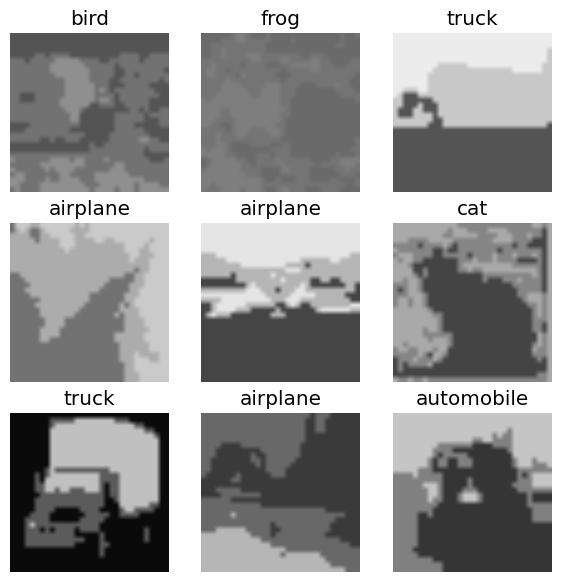

In [27]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_tri]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [28]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [29]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.766529,2.128977,0.234600,0.234600,0.225524,01:27


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.310306,2.027679,0.285300,0.285300,0.277315,01:20
1,2.094756,2.070881,0.302900,0.302900,0.290256,01:20
2,1.889472,1.913107,0.324800,0.324800,0.319575,01:16
3,1.716717,2.043373,0.320600,0.320600,0.309016,01:22
4,1.483200,2.109558,0.313900,0.313900,0.304440,01:17
5,1.225783,2.031723,0.346300,0.346300,0.340405,01:19
6,0.868463,2.316779,0.347800,0.347800,0.342479,01:17
7,0.614044,2.468250,0.347500,0.347500,0.330407,01:18
8,0.445762,2.806736,0.327900,0.327900,0.315447,01:18
9,0.335892,2.870427,0.333700,0.333700,0.327173,01:18


No improvement since epoch 2: early stopping

Tiempo de entrenamiento: 1110.96 segundos


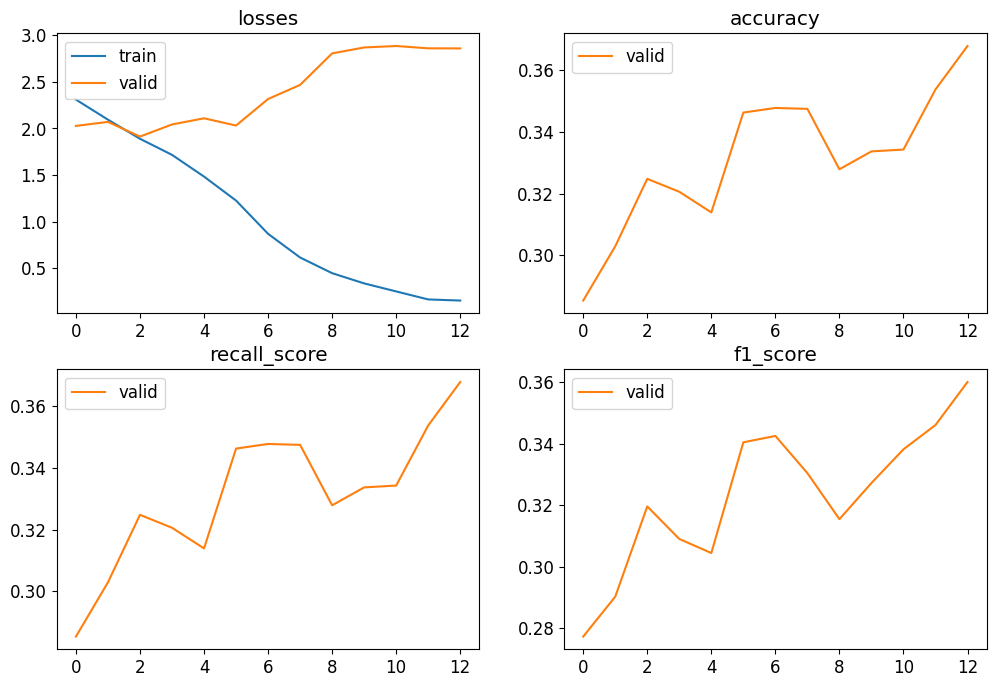

In [30]:
learn.recorder.plot_metrics()

In [31]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.8602
Accuracy: 0.3679
Recall: 0.3679
F1-Score: 0.3600


In [32]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_001_v3.pkl')

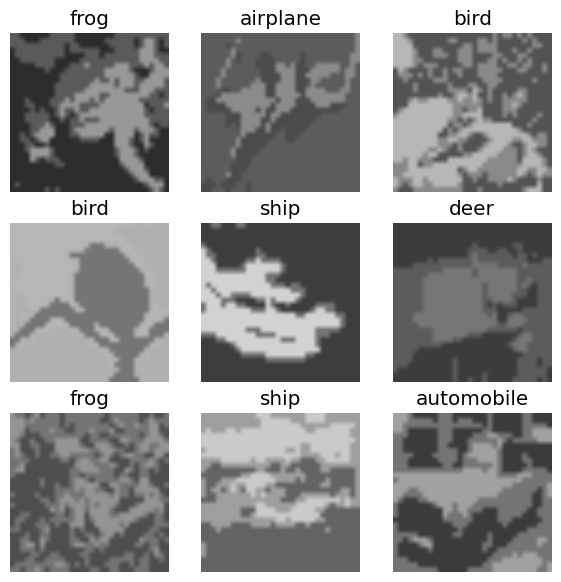

In [35]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

test_dls.show_batch(max_n=9, figsize=(7,7))

In [36]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [37]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.890900135040283
Accuracy: 0.3682892620563507
Recall (macro): 0.3683344260267313
F1 Score (macro): 0.35770030024285615


### Resnet 001 - Example 2

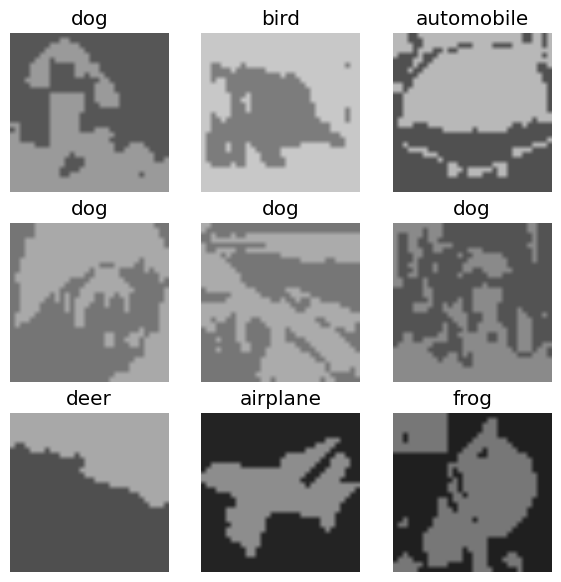

In [41]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [42]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [43]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.771232,2.194229,0.233000,0.233000,0.228425,01:13


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.360190,2.043381,0.275100,0.275100,0.260600,01:16
1,2.127521,1.987481,0.303200,0.303200,0.296845,01:17
2,1.981973,1.995078,0.299100,0.299100,0.293123,01:17
3,1.801966,2.100547,0.302900,0.302900,0.288961,01:17
4,1.590822,2.336413,0.288900,0.288900,0.269667,01:19
5,1.349624,2.165546,0.320200,0.320200,0.309158,01:17
6,0.987375,2.577606,0.313100,0.313100,0.296633,01:17


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 616.47 segundos


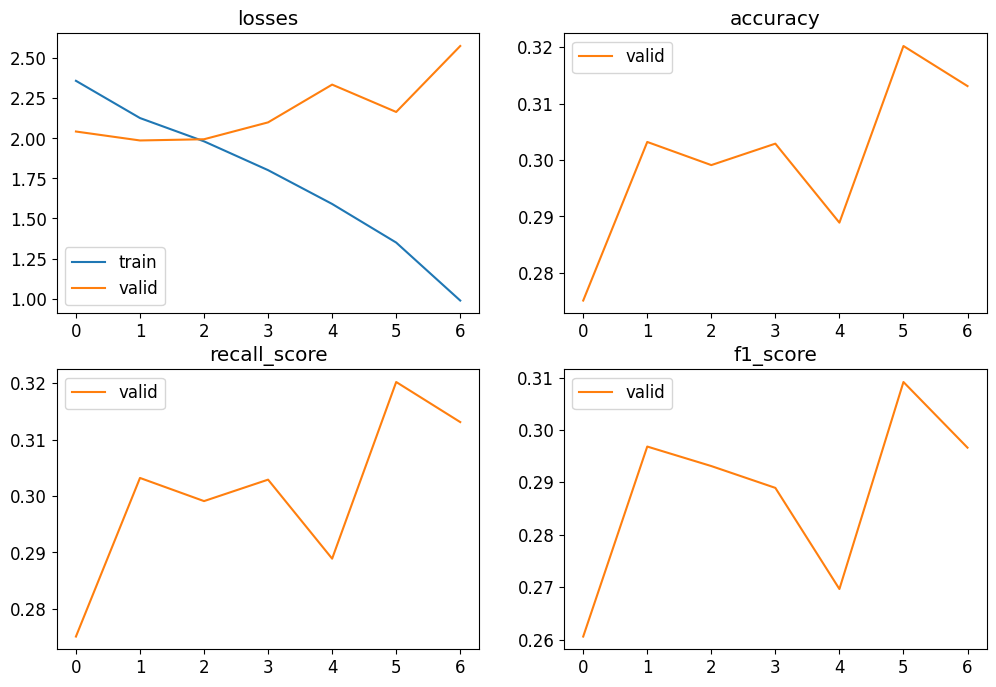

In [44]:
learn.recorder.plot_metrics()

In [45]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.5776
Accuracy: 0.3131
Recall: 0.3131
F1-Score: 0.2966


In [46]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_001_v3.pkl')

In [47]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [48]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [49]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.549943685531616
Accuracy: 0.3225160241127014
Recall (macro): 0.32260183533563613
F1 Score (macro): 0.30461252253472354


### Resnet 001 - Example 3

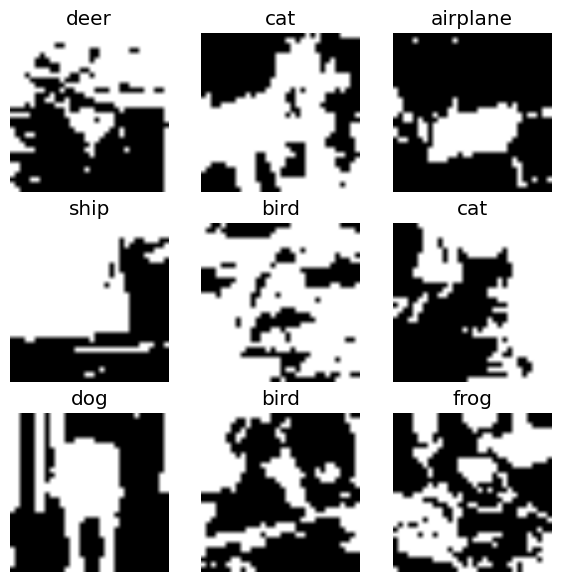

In [50]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [51]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [52]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.805919,2.098158,0.260500,0.260500,0.258883,00:55


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.151549,2.014742,0.304600,0.304600,0.293210,00:59
1,1.832322,2.025981,0.317700,0.317700,0.305551,01:00
2,1.506865,2.074028,0.325500,0.325500,0.318417,00:59
3,1.131851,2.567492,0.292000,0.292000,0.277112,00:59
4,0.731378,3.238358,0.254000,0.254000,0.239182,00:58
5,0.488849,3.361724,0.270000,0.270000,0.245321,00:58
6,0.353228,4.690512,0.252800,0.252800,0.216263,00:59
7,0.246708,3.446326,0.289800,0.289800,0.285648,00:59
8,0.205686,3.575579,0.279000,0.279000,0.260749,00:59
9,0.155603,3.488065,0.293000,0.293000,0.291141,00:58


No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 706.17 segundos


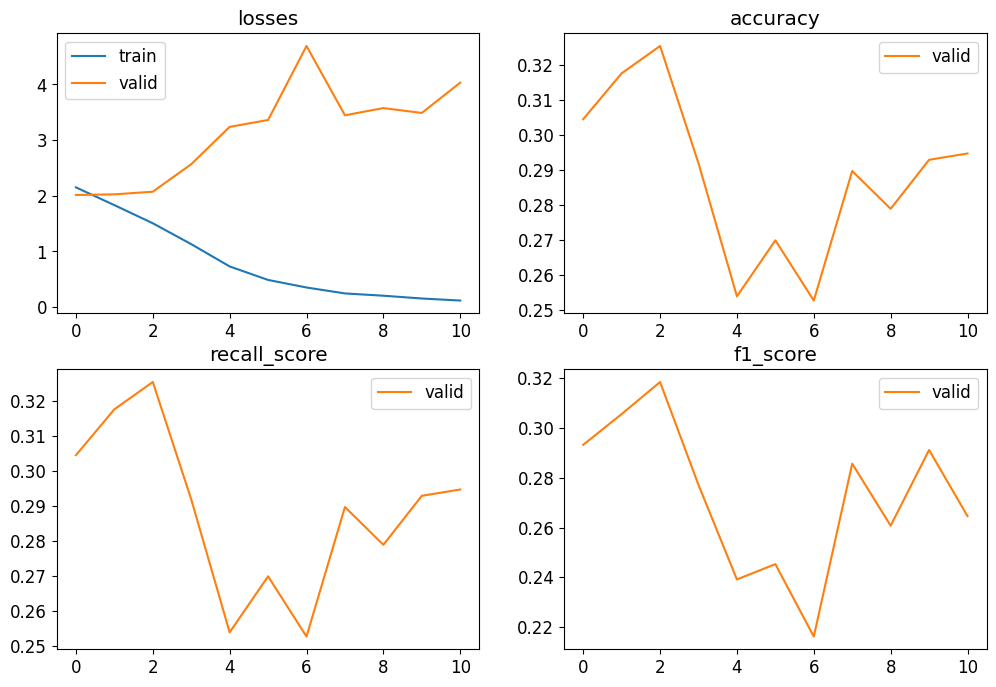

In [53]:
learn.recorder.plot_metrics()

In [54]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.0328
Accuracy: 0.2948
Recall: 0.2948
F1-Score: 0.2646


In [55]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_001_v3.pkl')

In [56]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [57]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [58]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.033317565917969
Accuracy: 0.2983773946762085
Recall (macro): 0.2984593606878393
F1 Score (macro): 0.2697864154101808


## Resnet 005

In [59]:
dst = base_path / "distilled_005"

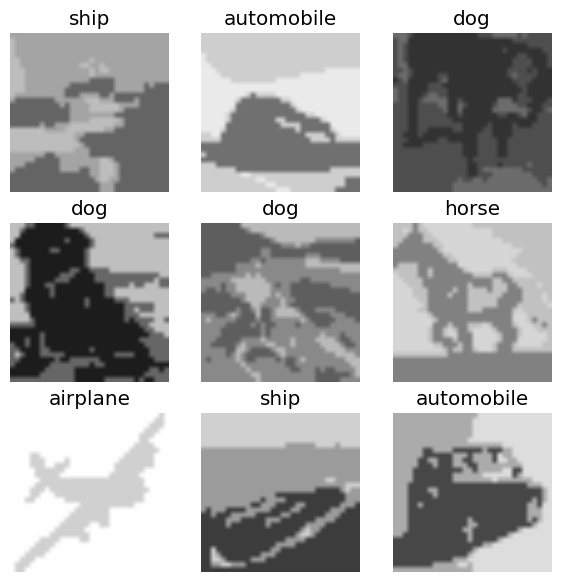

In [60]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_tri]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [61]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [62]:
start_time = time.time()
#learn.fit_one_cycle(60)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.807664,2.247062,0.230200,0.230200,0.224161,01:08


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.367161,1.934937,0.300600,0.300600,0.289333,01:11
1,2.111065,1.880862,0.325800,0.325800,0.319664,01:09
2,1.957120,1.997717,0.320300,0.320300,0.309442,01:12
3,1.772271,2.027008,0.320800,0.320800,0.303001,01:11
4,1.507190,2.361291,0.306200,0.306200,0.282850,01:11
5,1.204138,2.273895,0.315800,0.315800,0.307456,01:10
6,0.884281,2.535472,0.299800,0.299800,0.297753,01:10
7,0.571566,2.523656,0.332300,0.332300,0.326062,01:10
8,0.420129,2.773051,0.313900,0.313900,0.306540,01:10
9,0.312599,3.015025,0.343100,0.343100,0.328554,01:09


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 917.59 segundos


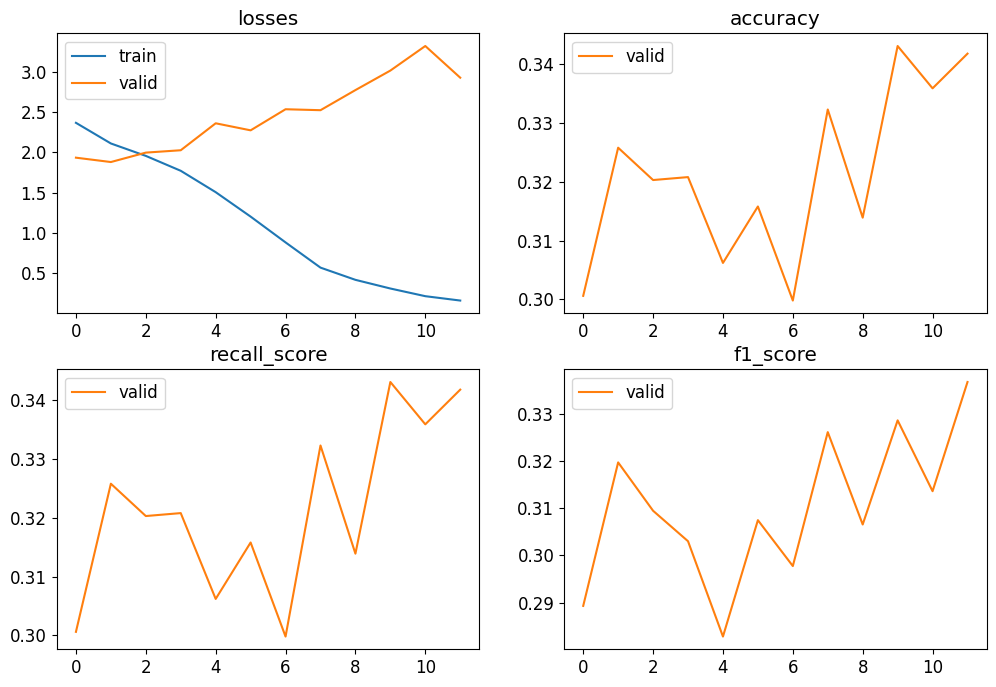

In [63]:
learn.recorder.plot_metrics()

In [64]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 2.9266
Accuracy: 0.3418
Recall: 0.3418
F1-Score: 0.3367


In [65]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_005_v3.pkl')

In [66]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_tri],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [67]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [68]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.9139506816864014
Accuracy: 0.3353365361690521
Recall (macro): 0.33532233473037637
F1 Score (macro): 0.3282339920840027


### Resnet 005 - Example 2

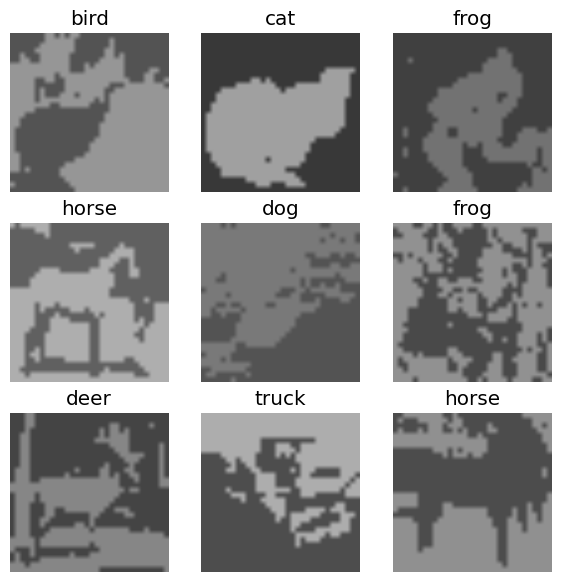

In [69]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [70]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [71]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.832833,2.208945,0.221700,0.221700,0.202015,01:05


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.423722,2.022089,0.271600,0.271600,0.267378,01:10
1,2.211691,1.972520,0.287300,0.287300,0.281833,01:11
2,2.018417,2.012111,0.295200,0.295200,0.287631,01:11
3,1.840076,2.054856,0.296800,0.296800,0.283138,01:11
4,1.607768,2.263386,0.290600,0.290600,0.268357,01:11
5,1.228533,2.331462,0.293600,0.293600,0.289106,01:11
6,0.914347,2.990797,0.247100,0.247100,0.218972,01:11
7,0.589081,2.599439,0.297500,0.297500,0.295540,01:11
8,0.453821,2.815706,0.298000,0.298000,0.296109,01:10
9,0.308354,2.878613,0.314900,0.314900,0.304056,01:08


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 910.05 segundos


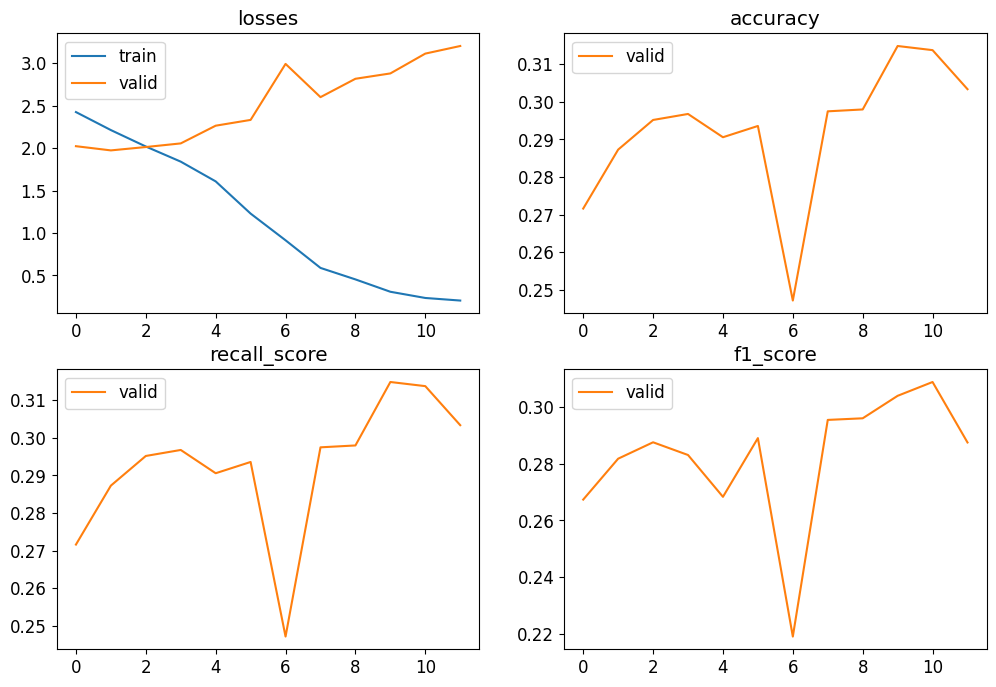

In [72]:
learn.recorder.plot_metrics()

In [73]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.2015
Accuracy: 0.3034
Recall: 0.3034
F1-Score: 0.2876


In [74]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_005_v3.pkl')

In [76]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [77]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [78]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.1715283393859863
Accuracy: 0.30739182233810425
Recall (macro): 0.30744603849270236
F1 Score (macro): 0.28982622877794917


### Resnet 005 - Example 3

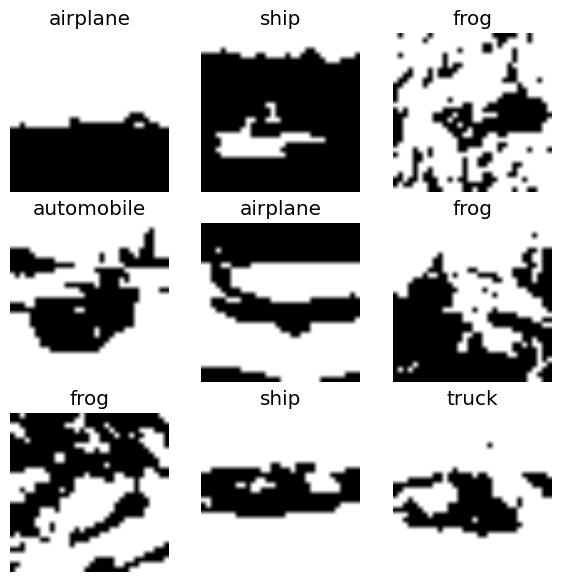

In [79]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [80]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [81]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.892594,2.240382,0.255900,0.255900,0.245413,00:50


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.250172,2.006965,0.295900,0.295900,0.289038,00:54
1,1.916223,2.058295,0.295900,0.295900,0.288536,00:55
2,1.601656,2.194750,0.291100,0.291100,0.279430,00:55
3,1.188300,2.204484,0.300300,0.300300,0.298464,00:55
4,0.749175,2.924809,0.282600,0.282600,0.250539,00:56
5,0.496965,3.349644,0.257400,0.257400,0.237408,00:57
6,0.331119,3.042865,0.298100,0.298100,0.276359,00:55
7,0.281812,3.949540,0.262800,0.262800,0.237953,00:55
8,0.194071,4.657272,0.227800,0.227800,0.205062,00:56
9,0.153319,4.192544,0.264100,0.264100,0.241412,00:55


No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 665.07 segundos


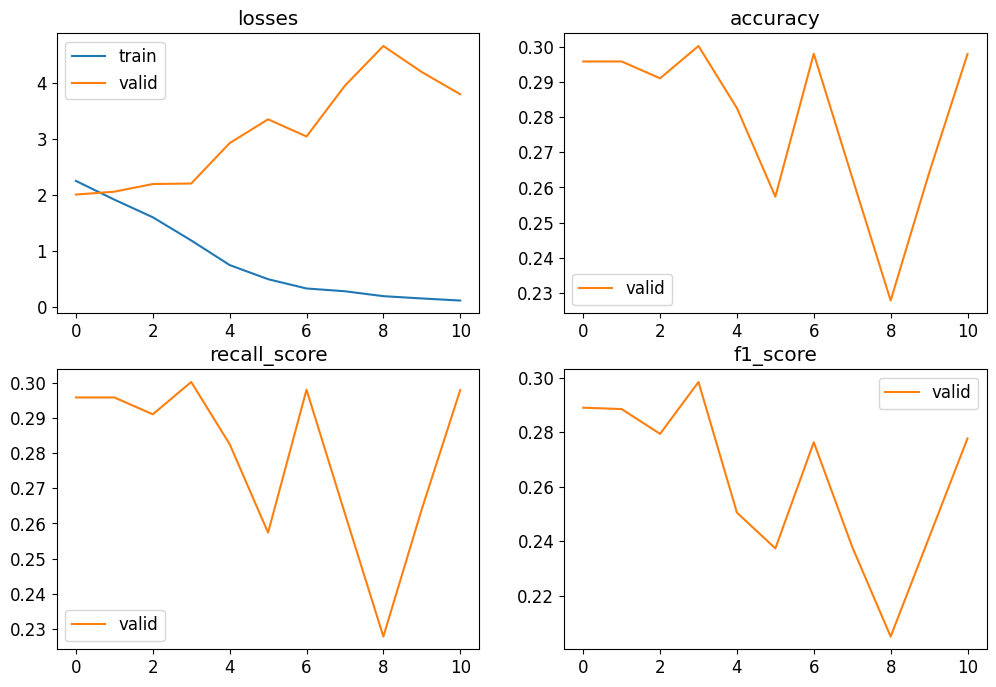

In [82]:
learn.recorder.plot_metrics()

In [83]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.7964
Accuracy: 0.2980
Recall: 0.2980
F1-Score: 0.2778


In [84]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_005_v3.pkl')

In [85]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [86]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [87]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.8050596714019775
Accuracy: 0.30258414149284363
Recall (macro): 0.3025805783325169
F1 Score (macro): 0.2834539248269109


## Resnet 0001

In [88]:
dst = base_path / "distilled_0001"

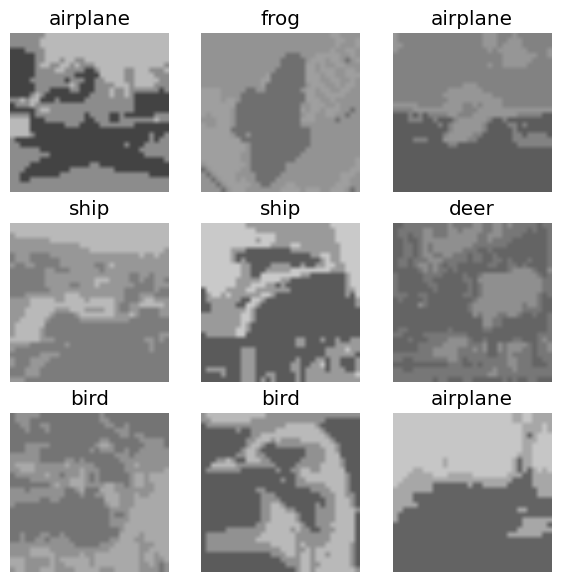

In [89]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [90]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [91]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.433528,2.167432,0.242400,0.242400,0.232028,01:46


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.987696,1.951180,0.320000,0.320000,0.305159,01:56
1,1.798328,1.956380,0.335900,0.335900,0.311792,01:50
2,1.649260,2.063438,0.326700,0.326700,0.307100,01:50
3,1.524667,1.837085,0.370700,0.370700,0.365472,01:49
4,1.355924,2.072538,0.350700,0.350700,0.340083,01:50
5,1.131364,2.018688,0.365400,0.365400,0.350743,01:50
6,0.898469,2.164566,0.377600,0.377600,0.362958,01:49
7,0.637085,2.946674,0.353700,0.353700,0.329557,01:51
8,0.454854,3.012489,0.374700,0.374700,0.360082,01:51


No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 1107.13 segundos


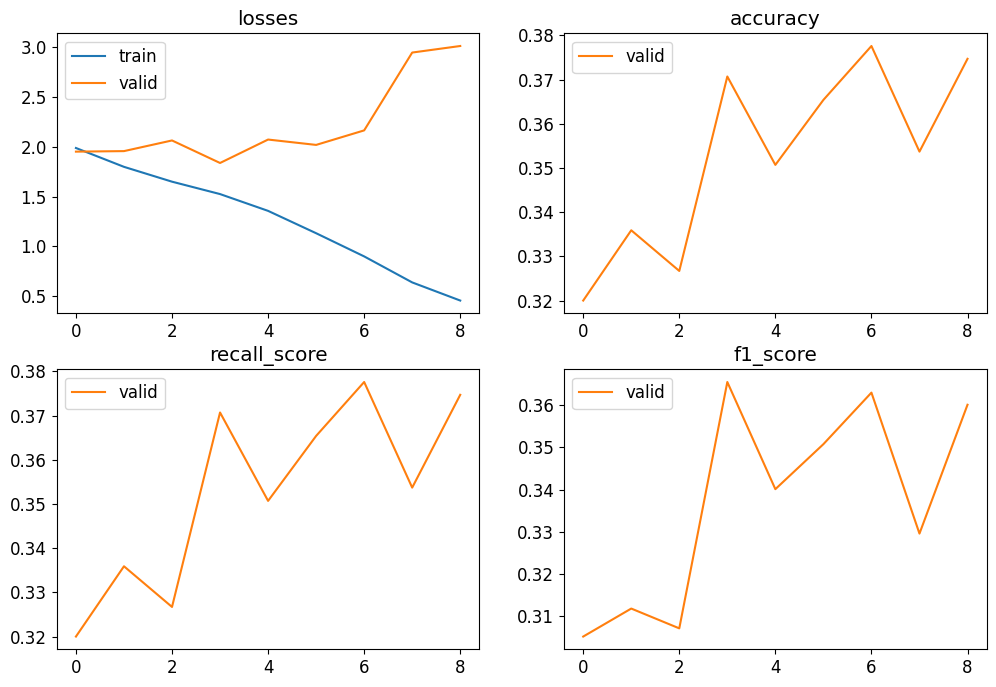

In [92]:
learn.recorder.plot_metrics()

In [93]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.0125
Accuracy: 0.3747
Recall: 0.3747
F1-Score: 0.3601


In [94]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_0001_v3.pkl')

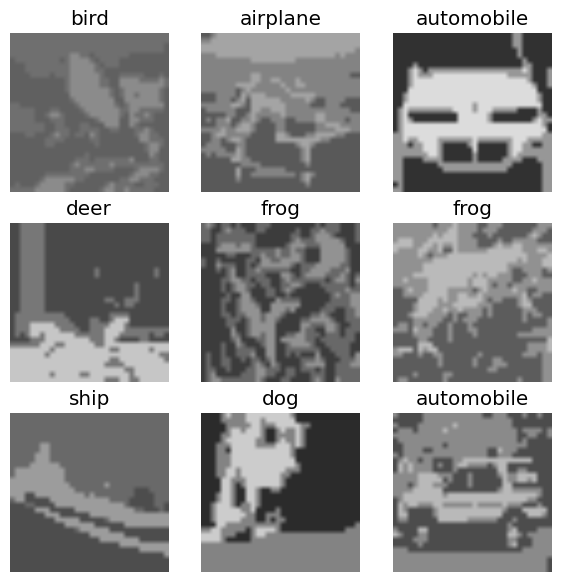

In [96]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

test_dls.show_batch(max_n=9, figsize=(7,7))

In [97]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [98]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.9890973567962646
Accuracy: 0.36798879504203796
Recall (macro): 0.36801103207918845
F1 Score (macro): 0.352641618562868


### Resnet 0001 - Example 2

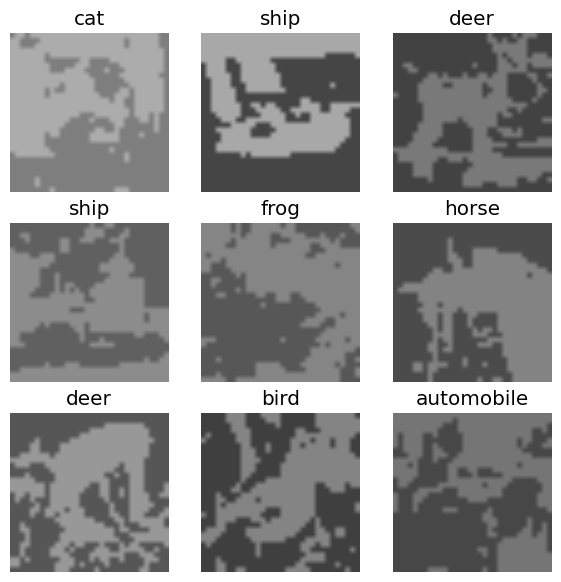

In [99]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [100]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [101]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.500350,2.352901,0.206600,0.206600,0.192690,01:45


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.088572,2.028044,0.281300,0.281300,0.269453,01:51
1,1.893823,2.019651,0.302800,0.302800,0.294763,01:52
2,1.717804,1.961157,0.330200,0.330200,0.315467,01:52
3,1.577982,1.958211,0.324400,0.324400,0.315504,01:54
4,1.392608,1.995574,0.353800,0.353800,0.346374,01:53
5,1.171699,2.323119,0.323600,0.323600,0.305843,01:56
6,0.911342,2.349781,0.350900,0.350900,0.343091,01:54
7,0.646533,2.749868,0.341300,0.341300,0.333495,01:51
8,0.475515,3.269253,0.330900,0.330900,0.316624,01:51
9,0.338707,2.990452,0.358000,0.358000,0.347546,01:51


No improvement since epoch 3: early stopping

Tiempo de entrenamiento: 1714.84 segundos


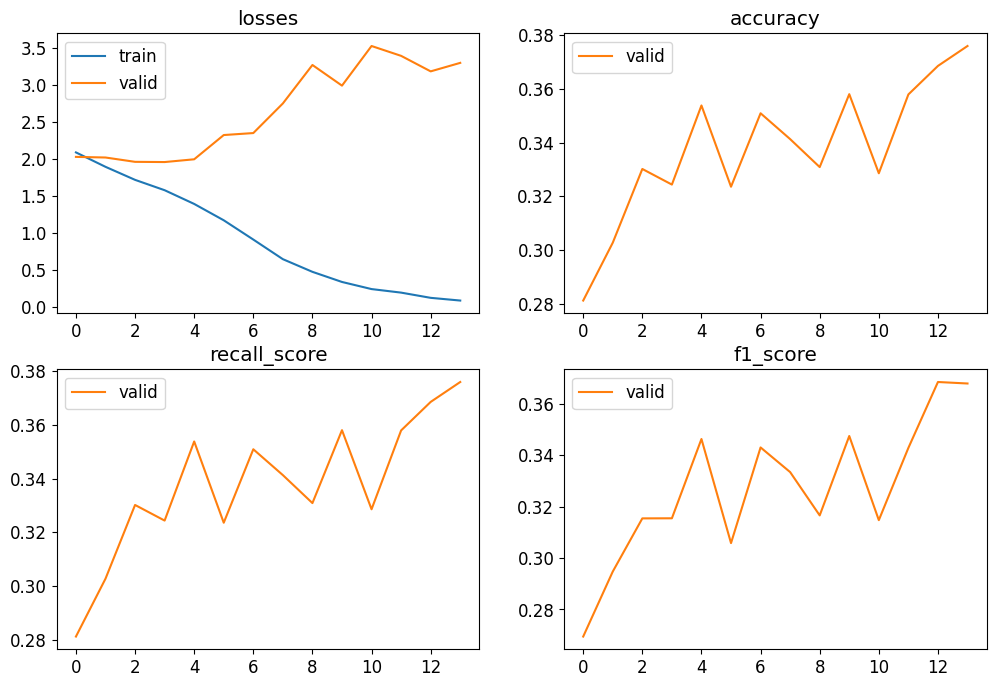

In [102]:
learn.recorder.plot_metrics()

In [103]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 3.2979
Accuracy: 0.3759
Recall: 0.3759
F1-Score: 0.3680


In [104]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')

In [105]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [106]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [107]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.386260986328125
Accuracy: 0.37379807233810425
Recall (macro): 0.3737280466347336
F1 Score (macro): 0.3666020285503922


### Resnet 0001 - Example 3

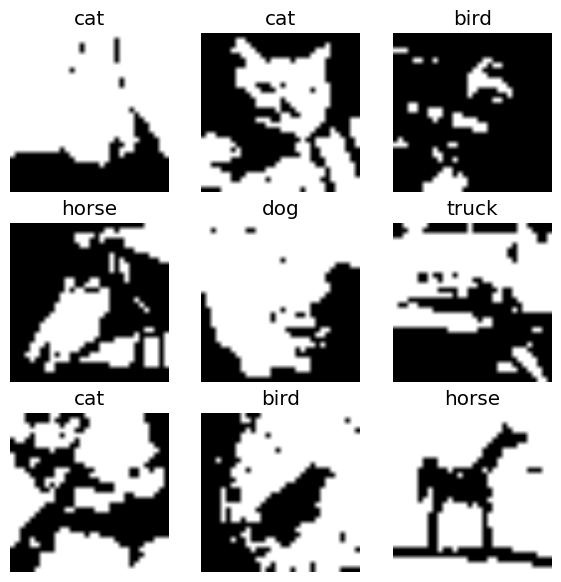

In [108]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [109]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [110]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.455102,2.204258,0.236600,0.236600,0.234232,01:25


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.932993,1.948882,0.317200,0.317200,0.310743,01:36
1,1.652488,1.921337,0.334100,0.334100,0.331330,01:34
2,1.344201,1.978266,0.353800,0.353800,0.351038,01:37
3,1.067478,2.278724,0.315300,0.315300,0.309059,01:36
4,0.700301,2.829087,0.311100,0.311100,0.291177,01:35
5,0.522127,3.011976,0.325200,0.325200,0.313555,01:34
6,0.418009,3.217807,0.323500,0.323500,0.312646,01:37
7,0.301004,4.446170,0.263200,0.263200,0.242183,01:37
8,0.255319,3.523679,0.331600,0.331600,0.315273,01:36
9,0.194303,5.037981,0.264300,0.264300,0.243828,01:35


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 1243.04 segundos


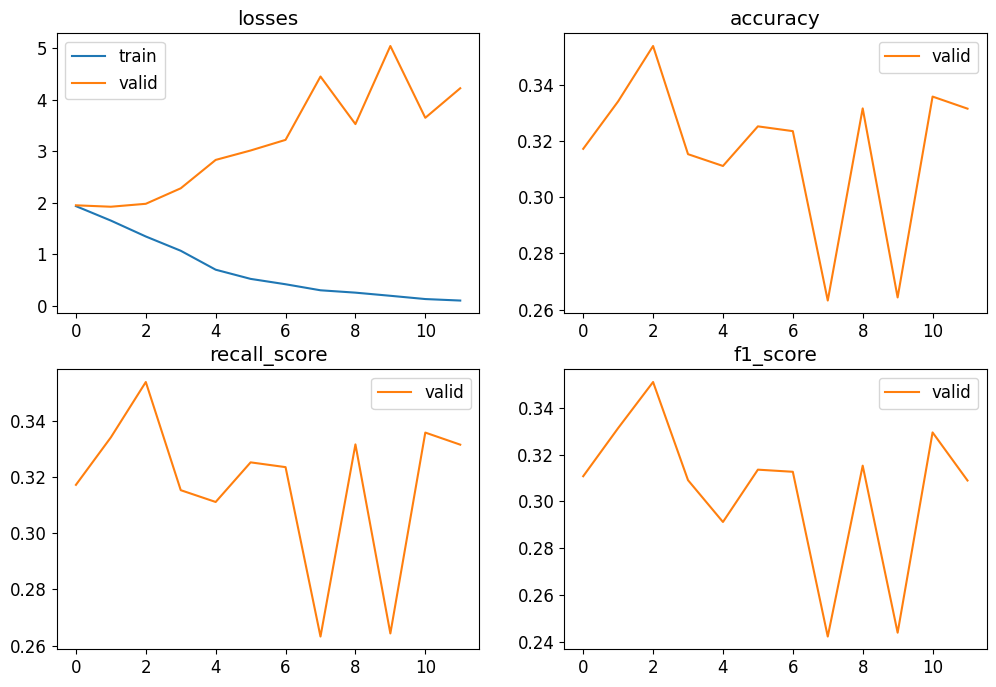

In [111]:
learn.recorder.plot_metrics()

In [112]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.2188
Accuracy: 0.3315
Recall: 0.3315
F1-Score: 0.3089


In [113]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')

In [114]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [115]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [116]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.202967166900635
Accuracy: 0.3404447138309479
Recall (macro): 0.3405434633371872
F1 Score (macro): 0.31573683689366716
